In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from keras.preprocessing.image import img_to_array, load_img

from keras import backend as K

from keras.utils import to_categorical
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50

from keras.layers import *
from keras.models import Model, load_model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.layers import Reshape

import threading
import pickle
import cv2
from cv2 import VideoWriter, VideoWriter_fourcc
import skvideo.io
import imageio


import io
import base64
from IPython.display import HTML

%matplotlib inline

Using TensorFlow backend.


In [4]:
train_path = "dashcam/frames/training/positive"
test_path = "dashcam/frames/testing/positive"

frames_path = {}

train_data = []
test_data = []

In [5]:
def make_sequences(frames, mode):
    frames = sorted(frames)
    sequences = []

    for i in range(0, 100, 25):
        sequence = frames[i:(i + 25)]
        if i < 75:
            label = np.zeros(25)
        else:
            label = np.concatenate((np.zeros(15), np.ones(10)), axis = 0)
        item = sequence, label
        if(mode == "train"):
            train_data.append(item)
        elif(mode == "test"):
            test_data.append(item)

In [6]:
for category in ["train", "test"]:
    data_path = train_path if category == "train" else test_path
    
    for video in os.listdir(data_path):
        frames = []
        for frame in os.listdir(data_path + "/" + video):
            frames.append(video + "_" + frame)
            frames_path[video + "_" + frame] = data_path + "/" + video
        if(len(frames) == 100):
            make_sequences(frames, category)

In [7]:
def image_to_tensor(filename):
  
    tokens = filename.split("_")
    im = load_img(frames_path[filename] + "/frame_" + tokens[2], target_size = (256, 256))
    im = img_to_array(im)
    im =  im / 255.
    #plt.imshow(im.astype(np.uint8))

    return im

In [8]:
def sequence_prep(sequence):
    x, y = sequence
    images = []

    for filename in x:
        im = image_to_tensor(filename)
        images.append(im)

    images = np.array(images)  # (25, 256, 256, 3)
    labels = np.reshape(y, (images.shape[0], 1))   # (25, 1)

    return images, labels

In [9]:
def batch_prep(batch):
  
    batch_x = []
    batch_y = []

    for sequence in batch:
        images, labels = sequence_prep(sequence)
        batch_x.append(images)
        batch_y.append(labels)

    batch_x = np.array(batch_x)
    batch_y = np.array(batch_y)

    #print("(batch_size, no_of_frames, img_height, img_width, channels) = " + str(batch_x.shape))
    #print("(batch_size, no_of_frames, class_value) = " + str(batch_y.shape))

    return batch_x, batch_y

In [10]:
class threadsafe_iterator:
    def __init__(self, iterator):
        self.iterator = iterator
        self.lock = threading.Lock()

    def __iter__(self):
        return self

    def __next__(self):
        with self.lock:
            return next(self.iterator)

def threadsafe_generator(func):
    """Decorator"""
    def gen(*a, **kw):
        return threadsafe_iterator(func(*a, **kw))
    return gen

In [11]:
@threadsafe_generator
def data_generator(mode):
    
    data = train_data if mode == "train" else test_data
    np.random.shuffle(data)
  
    batch_size = 10
    nb_batch = len(data) // batch_size
    
    print("Mode: " + mode + " => data generator in work to produce: " + str(nb_batch) + " batches from " + str(len(data)) + " data instances. ")

    while True:
        for i in range(nb_batch):

            beg = i * batch_size
            end = (i * batch_size + batch_size) if i * batch_size < len(data) else -1

            batch = data[beg : end]

            batch_x, batch_y = batch_prep(batch)

            #ENSURING THAT THE IMAGES IN THE TENSOR ARE AS EXPECTED FROM THE DIMENSION OF THE TENSOR
            #batch_x = np.reshape(batch_x, (250, 256, 256, 3))
            #plt.imshow(batch_x[100, :, :, :].astype(np.uint8))

            yield batch_x, batch_y

In [12]:
def weighted_binary_crossentropy( y_true, y_pred, weight = 9. ) :
    y_true = K.clip(y_true, K.epsilon(), 1)
    y_pred = K.clip(y_pred, K.epsilon(), 1)
    logloss = -(y_true * K.log(y_pred) * weight + (1 - y_true) * K.log(1 - y_pred))
    return K.mean( logloss, axis=-1)

In [13]:
class LRCN():
    
    def __init__(self, seq_length, saved_model=None):
        
        self.seq_length = seq_length
        self.saved_model = saved_model
        
        metrics = ['accuracy']
            
        if self.saved_model is not None:
            print("Loading model %s" % self.saved_model)
            self.model = load_model(self.saved_model)
            
        else:
            self.input_shape = (seq_length, 256, 256, 3)
            self.model = self.lrcn()
            
        optimizer = Adam(lr=0.001)
        self.model.compile(loss=[ weighted_binary_crossentropy ], optimizer=optimizer, metrics=metrics)

        #self.model.summary()
    
    def lrcn(self):
        
        vgg = VGG16(include_top=False, weights='imagenet', input_tensor=None, input_shape=(256, 256, 3), pooling="max")
        
        for layer in vgg.layers:
            layer.trainable = False
            
        inp = Input(shape = (256, 256, 3))
        x = vgg(inp)
        cnn = Model(inputs = inp, outputs = x)

        inp = Input(shape = self.input_shape)
        x = TimeDistributed(cnn)(inp)
        x = LSTM(units = 512, return_sequences = True)(x)
        
        x = TimeDistributed(Dense(units = 128, activation = "relu"))(x)
        x = TimeDistributed(Dense(units = 64, activation = "relu"))(x)
        x = TimeDistributed(Dense(units = 8, activation = "relu"))(x)
        x = TimeDistributed(Dense(units = 1, activation = "sigmoid"))(x)
        
        model = Model(inputs = inp, outputs = x)
        #model.summary()
        
        return model

In [ ]:
checkpointer = ModelCheckpoint(
        filepath=os.path.join('saved_models', 'accident_classifier_weighted', 'accident_classifier_nonweighted' + \
            '.{epoch:03d}-{loss:.3f}.hdf5'),
        verbose=1,
        save_weights_only=True,
        save_best_only=True)

train_datagen = data_generator("train")
test_datagen = data_generator("test")
lrcn = LRCN(seq_length = 25, saved_model = None)

history = lrcn.model.fit_generator(generator = train_datagen, steps_per_epoch = 182, epochs = 30, verbose = 1, workers = 4, shuffle = False, validation_data = test_datagen, validation_steps = 60, callbacks = [checkpointer], initial_epoch = 0)

In [ ]:
pickle_out = open("saved_models/accident_classifier_weighted/history_accident_classifier_weighted_e30.pickle","wb")
pickle.dump(history.history, pickle_out)
pickle_out.close()

In [2]:
pickle_in = open("saved_models/accident_classifier_weighted/history_accident_classifier_weighted_e30.pickle","rb")
loaded_history = pickle.load(pickle_in)

val_loss = loaded_history["val_loss"]
val_acc = loaded_history["val_acc"]

training_loss = loaded_history["loss"]
training_acc = loaded_history["acc"]

epochs = range(30)

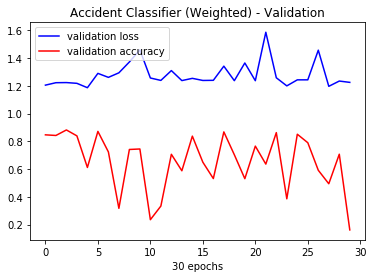

In [3]:
plt.plot(epochs, val_loss, '-b', label='validation loss')
plt.plot(epochs, val_acc, '-r', label='validation accuracy')

plt.xlabel("30 epochs")
plt.legend(loc='upper left')
plt.title("Accident Classifier (Weighted) - Validation")

plt.savefig("figures/accident_classifier_weighted_e30_val" + ".png")  
plt.show()

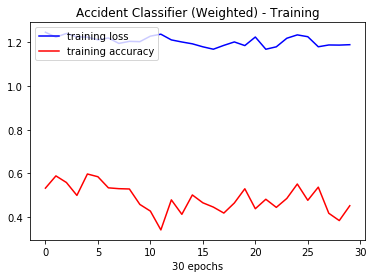

In [4]:
plt.plot(epochs, training_loss, '-b', label='training loss')
plt.plot(epochs, training_acc, '-r', label='training accuracy')

plt.xlabel("30 epochs")
plt.legend(loc='upper left')
plt.title("Accident Classifier (Weighted) - Training")

plt.savefig("figures/accident_classifier_weighted_e30_train" + ".png")  
plt.show()

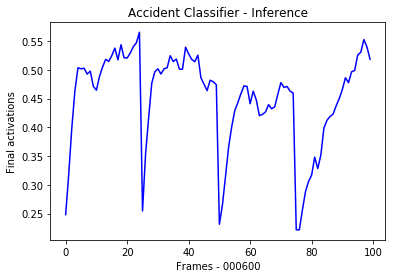

In [28]:
model_inference("dashcam/frames/testing/positive/000600")

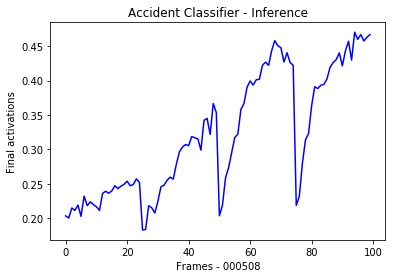

In [29]:
model_inference("dashcam/frames/testing/positive/000508")

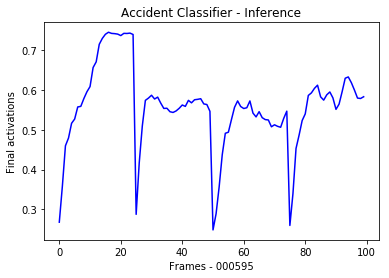

In [31]:
model_inference("dashcam/frames/testing/positive/000595")

In [27]:
def model_inference(video_path): 
    
    file_idx = video_path.split("/")[-1]
    
    frame_names = []
    for frame in os.listdir(video_path):
        frame_names.append(frame)
    frame_names = sorted(frame_names)

    frames = []
    for frame in frame_names:
        img = load_img(video_path + "/" + frame, target_size = (256, 256))
        img = img_to_array(img)
        img =  img / 255.
        frames.append(img)
    frames = np.array(frames)

    lrcn = LRCN(seq_length = 25, saved_model = None)    
    lrcn.model.load_weights("saved_models/accident_classifier_weighted/accident_classifier_weighted.005-1.224.hdf5")
    
    predictions = []
    for i in range(0, 100, 25):
        input_sequence = frames[i : i + 25]
        input_sequence = np.array([input_sequence])
        pred = lrcn.model.predict(input_sequence)
        pred = np.reshape(pred, (25, 1))      
        for j in pred:
            predictions.append(j[0])

    for i in range(100):
        plt.plot(i, predictions[i], '-b', label='validation activations')
        plt.ylim([0, 0.2])
        plt.xlim([0, 100])
        plt.ylabel("Final activations")
        plt.xlabel("Frames - " + file_idx)
        plt.title("Accident Classifier - Inference")
        plt.savefig("figures/inference_video/accident_classifier_weighted/000410/000410_" + str(i) + ".png")

In [18]:
def model_inference(video_path): 
    
    file_idx = video_path.split("/")[-1]
    
    frame_names = []
    for frame in os.listdir(video_path):
        frame_names.append(frame)
    frame_names = sorted(frame_names)

    frames = []
    for frame in frame_names:
        img = load_img(video_path + "/" + frame, target_size = (256, 256))
        img = img_to_array(img)
        img =  img / 255.
        frames.append(img)
    frames = np.array(frames)

    lrcn = LRCN(seq_length = 25, saved_model = None)
    lrcn.model.load_weights("saved_models/accident_classifier_weighted/accident_classifier_weighted.005-1.224.hdf5")
    
    predictions = []
    for i in range(0, 100, 25):
        input_sequence = frames[i : i + 25]
        input_sequence = np.array([input_sequence])
        pred = lrcn.model.predict(input_sequence)
        pred = np.reshape(pred, (20, 1))      
        for j in pred:
            predictions.append(j[0])
    plt.figure(figsize = (20,10))      
    for i in range(100):
        plt.subplot(1,2,1)
        plt.imshow(frames[i])
        plt.subplot(1,2,2)
        plt.plot(predictions[:i], '-b', label='activations')
        plt.ylim([0, 0.2])
        plt.xlim([0, 100])
        plt.ylabel("Final activations")
        plt.xlabel("Frames - " + file_idx)
        plt.title("Accident Classifier - Inference")
        plt.savefig("figures/inference_video/accident_classifier_weighted/000410/000" + str(file_idx) +  "_" + str(i) + ".png")

In [19]:
model_inference("dashcam/frames/testing/positive/000595")

ResourceExhaustedError: OOM when allocating tensor with shape[3,3,512,512] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node block5_conv2_2/random_uniform/RandomUniform (defined at /home/amrit/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4139) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op 'block5_conv2_2/random_uniform/RandomUniform', defined at:
  File "/home/amrit/anaconda3/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/amrit/anaconda3/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/amrit/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/amrit/anaconda3/lib/python3.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/amrit/anaconda3/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/home/amrit/anaconda3/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/amrit/anaconda3/lib/python3.7/asyncio/base_events.py", line 539, in run_forever
    self._run_once()
  File "/home/amrit/anaconda3/lib/python3.7/asyncio/base_events.py", line 1775, in _run_once
    handle._run()
  File "/home/amrit/anaconda3/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/amrit/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/amrit/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/amrit/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 781, in inner
    self.run()
  File "/home/amrit/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 742, in run
    yielded = self.gen.send(value)
  File "/home/amrit/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/amrit/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/amrit/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/amrit/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/amrit/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "/home/amrit/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/amrit/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/amrit/anaconda3/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/amrit/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2848, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/amrit/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2874, in _run_cell
    return runner(coro)
  File "/home/amrit/anaconda3/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/home/amrit/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3049, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/amrit/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3220, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/home/amrit/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-19-ae72a0d05203>", line 1, in <module>
    model_inference("dashcam/frames/testing/positive/000595")
  File "<ipython-input-18-82827b8eb099>", line 18, in model_inference
    lrcn = LRCN(seq_length = 25, saved_model = None)
  File "<ipython-input-13-9926add9aad0>", line 16, in __init__
    self.model = self.lrcn()
  File "<ipython-input-13-9926add9aad0>", line 25, in lrcn
    vgg = VGG16(include_top=False, weights='imagenet', input_tensor=None, input_shape=(256, 256, 3), pooling="max")
  File "/home/amrit/anaconda3/lib/python3.7/site-packages/keras/applications/__init__.py", line 28, in wrapper
    return base_fun(*args, **kwargs)
  File "/home/amrit/anaconda3/lib/python3.7/site-packages/keras/applications/vgg16.py", line 11, in VGG16
    return vgg16.VGG16(*args, **kwargs)
  File "/home/amrit/anaconda3/lib/python3.7/site-packages/keras_applications/vgg16.py", line 168, in VGG16
    name='block5_conv2')(x)
  File "/home/amrit/anaconda3/lib/python3.7/site-packages/keras/engine/base_layer.py", line 431, in __call__
    self.build(unpack_singleton(input_shapes))
  File "/home/amrit/anaconda3/lib/python3.7/site-packages/keras/layers/convolutional.py", line 141, in build
    constraint=self.kernel_constraint)
  File "/home/amrit/anaconda3/lib/python3.7/site-packages/keras/legacy/interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "/home/amrit/anaconda3/lib/python3.7/site-packages/keras/engine/base_layer.py", line 249, in add_weight
    weight = K.variable(initializer(shape),
  File "/home/amrit/anaconda3/lib/python3.7/site-packages/keras/initializers.py", line 218, in __call__
    dtype=dtype, seed=self.seed)
  File "/home/amrit/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py", line 4139, in random_uniform
    dtype=dtype, seed=seed)
  File "/home/amrit/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/random_ops.py", line 247, in random_uniform
    rnd = gen_random_ops.random_uniform(shape, dtype, seed=seed1, seed2=seed2)
  File "/home/amrit/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/gen_random_ops.py", line 777, in random_uniform
    name=name)
  File "/home/amrit/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "/home/amrit/anaconda3/lib/python3.7/site-packages/tensorflow/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/home/amrit/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/ops.py", line 3300, in create_op
    op_def=op_def)
  File "/home/amrit/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/ops.py", line 1801, in __init__
    self._traceback = tf_stack.extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[3,3,512,512] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node block5_conv2_2/random_uniform/RandomUniform (defined at /home/amrit/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4139) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

